In [170]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from sklearn.model_selection import train_test_split

import math

In [171]:
# Current script
current_path = os.getcwd()

# Add utils folder to sys path 
sys.path.append(os.path.join(current_path, "utils"))

# Import the prewritten helper functions
from py_helper_functions import *

# Data

In [172]:
data = pd.read_csv("https://raw.githubusercontent.com/00Dabide/DA3-Assignment-2/main/listings.csv")
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,38768,https://www.airbnb.com/rooms/38768,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.75 · 1 bedroom · 3 ...,NaN,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,...,4.94,4.77,4.70,NaN,t,3,3,0,0,2.48
1,40625,https://www.airbnb.com/rooms/40625,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.85 · 2 bedrooms · 4...,NaN,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,...,4.94,4.59,4.72,NaN,t,15,14,1,0,1.24
2,51287,https://www.airbnb.com/rooms/51287,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.66 · Studio · 2 bed...,NaN,The neighbourhood has a lot of very nice littl...,https://a0.muscache.com/pictures/25163038/1c4e...,166283,...,4.95,4.86,4.59,NaN,f,3,3,0,0,2.36
3,70637,https://www.airbnb.com/rooms/70637,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.77 · 1 bedroom · 2 ...,NaN,NaN,https://a0.muscache.com/pictures/925691/c8c1bd...,358842,...,4.76,4.81,4.72,NaN,f,3,1,2,0,0.75
4,75500,https://www.airbnb.com/rooms/75500,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.45 · 2 bedrooms · 2...,NaN,NaN,https://a0.muscache.com/pictures/549090/b51ce4...,400857,...,4.67,4.08,4.42,NaN,f,1,1,0,0,0.08


In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14697 entries, 0 to 14696
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            14697 non-null  int64  
 1   listing_url                                   14697 non-null  object 
 2   scrape_id                                     14697 non-null  int64  
 3   last_scraped                                  14697 non-null  object 
 4   source                                        14697 non-null  object 
 5   name                                          14697 non-null  object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         7553 non-null   object 
 8   picture_url                                   14697 non-null  object 
 9   host_id                                       14697 non-null 

Usable columns:

- accommodates
- beds
- property_type
- room_type
- bathrooms_text
- neighbourhood_cleansed

- number_of_reviews
- flag_number_of_reviews


# Cleaning

In [174]:
# host_location my contains values, which are outside of Vienna, even Austria!!!

data["In_Austria"] = data["host_location"].str.contains("Vienna, Austria")
data = data.loc[data["In_Austria"] == True]
print(data["host_location"].value_counts())

data.fillna(0, inplace=True)

# replace price to int
data["price"] = data["price"].replace('[\$,]', '', regex=True).astype(float)

#flags

# has review (more than 0)
data["flag_number_of_reviews"] = data["number_of_reviews"] > 0
print(data["flag_number_of_reviews"].value_counts())

# has a score of at least 3.5
data["flag_review_scores_rating"] = (data["review_scores_rating"] >= 3.5)
print(data["flag_review_scores_rating"].value_counts())


host_location
Vienna, Austria    9561
Name: count, dtype: int64
flag_number_of_reviews
True     8234
False    1327
Name: count, dtype: int64
flag_review_scores_rating
True     8126
False    1435
Name: count, dtype: int64


# 3 Different models:
- Linear OLS regression
- Random Forest

In [175]:
#train and test data
data_train, data_holdout = train_test_split( data, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

((6692, 78), (2869, 78))

# OLS

# Random Forest

In [176]:
# basic variables
basic_vars = [
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed",
    "minimum_nights",
    "maximum_nights"
]

# reviews
reviews = [
    "number_of_reviews",
    "flag_number_of_reviews",
    "review_scores_rating",
    "flag_review_scores_rating",
]

# host dummy variables + instant_bookable
host = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable",
]

# interactions for the LASSO
# from ch14
X1 = [
    "accommodates:property_type",
    "room_type:property_type",
    "room_type:instant_bookable",
    "minimum_nights:property_type",
    "maximum_nights:property_type",
]
# with boroughs
X2 = [
    "property_type:neighbourhood_cleansed",
    "room_type:neighbourhood_cleansed",
    "accommodates:neighbourhood_cleansed",
]

In [177]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + host
predictors_E = basic_vars + reviews + host + X1 + X2

In [178]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [179]:
np.asarray(y)

array([[109.],
       [ 94.],
       [122.],
       ...,
       [100.],
       [ 90.],
       [ 48.]])

In [180]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 10.20.


In [181]:
rfr = RandomForestRegressor(random_state = 20240129)
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [182]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-135.502 total time=   0.4s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-77.182 total time=   0.4s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-88.783 total time=   0.4s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-71.587 total time=   0.4s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-121.168 total time=   0.4s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-138.358 total time=   0.3s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-79.959 total time=   0.4s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-90.500 total time=   0.3s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-74.090 total time=   0.4s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-123.584 total time=   0.3s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-139.380 total time=   0.3s
[CV 2/5] END ma

In [183]:
rf_model.cv_results_

{'mean_fit_time': array([0.48111987, 0.40789165, 0.35231252, 0.59002137, 0.46456981,
        0.40001817, 0.66583152, 0.57451811, 0.48209891, 0.77693658,
        0.61771746, 0.57427793]),
 'std_fit_time': array([0.01994818, 0.02724424, 0.00739712, 0.0240048 , 0.02845933,
        0.01359007, 0.01055701, 0.02847566, 0.02816359, 0.02659612,
        0.02333032, 0.03926837]),
 'mean_score_time': array([0.021738  , 0.01756964, 0.02353277, 0.01914134, 0.01555872,
        0.01555185, 0.01894994, 0.0173595 , 0.01596451, 0.02194343,
        0.01893692, 0.01715388]),
 'std_score_time': array([0.00387171, 0.002645  , 0.020636  , 0.0026192 , 0.00048821,
        0.0022439 , 0.00126242, 0.00119098, 0.00064218, 0.00327593,
        0.00303499, 0.00159795]),
 'param_max_features': masked_array(data=[6, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 12],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dty

In [184]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [185]:
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

In [186]:
df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-98.844389
1,6,10,-101.298069
2,6,15,-102.423499
3,8,5,-97.529817
4,8,10,-99.497187
5,8,15,-100.738839
6,10,5,-96.608698
7,10,10,-98.617125
8,10,15,-99.879674
9,12,5,-95.740740


In [187]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,98.84,101.30,102.42
8,97.53,99.50,100.74
10,96.61,98.62,99.88
12,95.74,97.92,99.07


In [188]:
rf_model.best_score_

-95.74074046637504

In [189]:
rf_model.best_params_

{'max_features': 12, 'min_samples_leaf': 5}

In [190]:
rf_model.best_estimator_

RandomForestRegressor(max_features=12, min_samples_leaf=5,
                      random_state=20240129)

In [191]:
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.40562097e-03,
       0.00000000e+00, 4.83589590e-06, 0.00000000e+00, 4.25610122e-04,
       7.10679588e-04, 0.00000000e+00, 1.27080253e-02, 1.67864179e-02,
       0.00000000e+00, 4.66466511e-05, 0.00000000e+00, 0.00000000e+00,
       1.05195880e-04, 0.00000000e+00, 1.33982048e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00299990e-04, 0.00000000e+00,
       5.69880487e-03, 6.27977447e-05, 3.88256056e-02, 2.05712894e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.47714416e-05,
       2.80238466e-02, 5.61455947e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.24940550e-05, 4.73065557e-04,
       0.00000000e+00, 4.75540783e-04, 0.00000000e+00, 3.99565953e-04,
       2.97378128e-02, 1.37942882e-03, 0.00000000e+00, 2.15963826e-02,
       3.53401222e-03, 1.17172110e-02, 1.22008822e-02, 4.03550297e-03,
       3.01626809e-02, 1.41763448e-04, 1.19405192e-02, 9.51484213e-05,
      

In [192]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
property_type[T.Entire cabin],0.000000
property_type[T.Entire chalet],0.000000
property_type[T.Entire condo],0.003406
property_type[T.Entire cottage],0.000000
...,...
beds,0.104104
minimum_nights,0.037009
maximum_nights,0.056071
number_of_reviews,0.052061


In [193]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [194]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,accommodates,17.5%,17.5%
1,beds,10.4%,27.9%
2,neighbourhood_cleansed[T.Innere Stadt],9.0%,36.9%
3,maximum_nights,5.6%,42.5%
4,number_of_reviews,5.2%,47.7%
5,review_scores_rating,5.0%,52.7%
6,instant_bookable[T.t],4.3%,57.0%
7,property_type[T.Private room in rental unit],3.9%,60.8%
8,host_is_superhost[T.t],3.8%,64.6%
9,minimum_nights,3.7%,68.3%


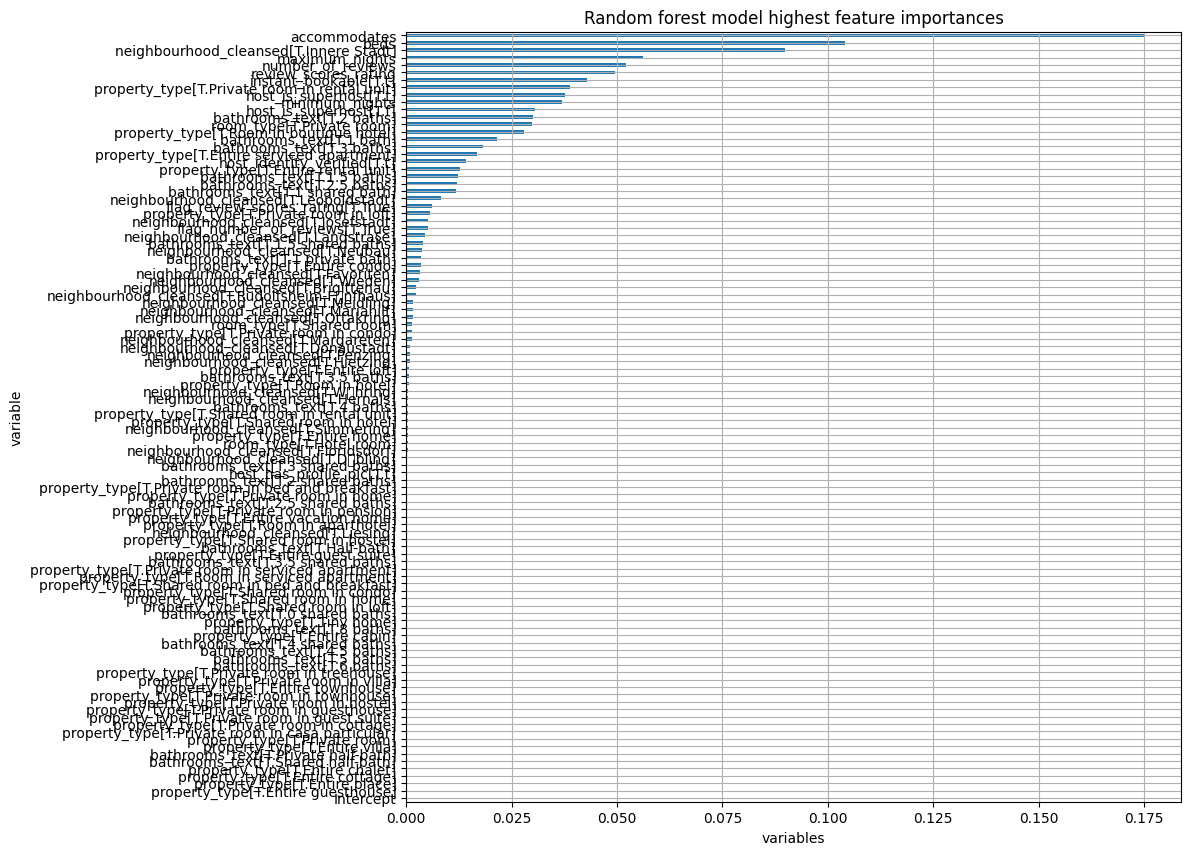

In [195]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [196]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

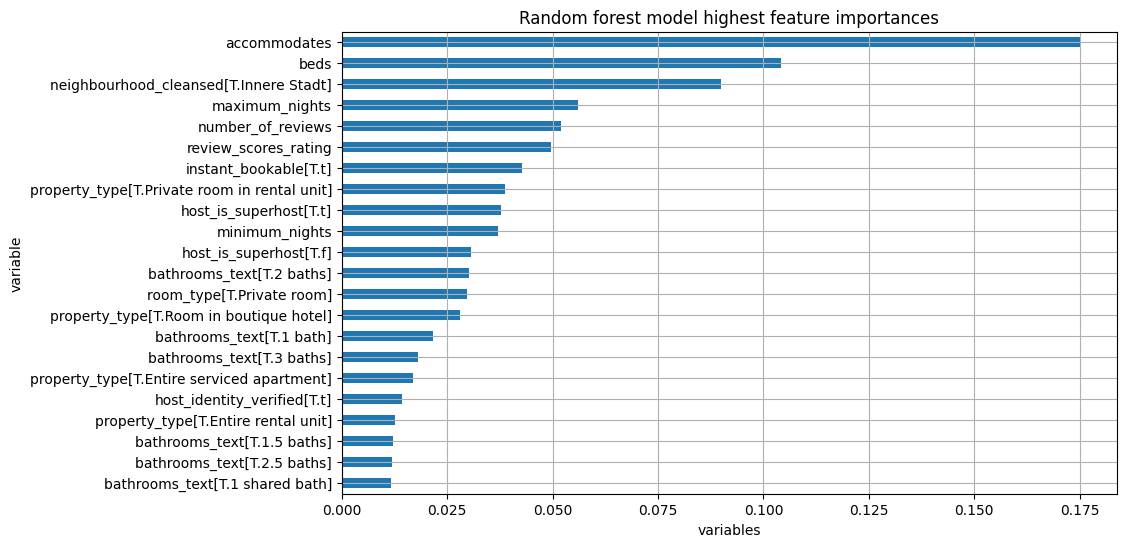

In [197]:
df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [198]:
categorical_columns = [
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed",
]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [199]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [200]:
%%time
rf_pipeline.fit(data_train[predictors_2],data_train.price)

ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

In [201]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

In [202]:
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)

,0
accommodates,0.037714
beds,0.012090
property_type,0.032438
room_type,0.025421
bathrooms_text,0.030506
neighbourhood_cleansed,0.043379
minimum_nights,0.005065
maximum_nights,0.010990
number_of_reviews,0.000000
flag_number_of_reviews,0.000000
